In [95]:
import os
import json
import re
import pandas as pd

# Annotations and Metadata
def load_json_files(folder_path):
    data = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.json'):
            with open(os.path.join(folder_path, file_name), 'r') as f:
                data.append(json.load(f))
    return data

# Folders
annotations_folder = r"B:\annotations\sample\coco\annotations_04"
metadata_folder = r"B:\annotations\sample\ocular-json"

# Load all annotations and metadata
annotations = load_json_files(annotations_folder)
metadata = load_json_files(metadata_folder)

In [96]:
# Extract timestamp from file name or file path
def extract_timestamp(file_path):
    match = re.search(r'Ocular_(\d{4}-\d{2}-\d{2}_\d{2}_\d{2}_\d{2})', file_path)
    return match.group(1) if match else None

metadata_list = []
for meta in metadata:
    if isinstance(meta, dict):
        # Processing each key-value pair in the dictionary
        timestamp = extract_timestamp(meta.get('file_path', None))
        if timestamp:
            metadata_list.append({
                'timestamp': timestamp,
                'zoom_ration': meta.get('zoom_ration', None),
                'slide_name': meta.get('slide_name', None),
                'username': meta.get('username', None),
                'stain': meta.get('stain', None)
            })
        else:
            print('No timestamp found')

metadata_df = pd.DataFrame(metadata_list)

In [117]:
import pandas as pd

# Based on the timestamp pattern in the file paths match annotations to metadata
annotation_list = []
for annotation_file in annotations:
    for image in annotation_file['images']:
        file_name = image['file_name']
        image_id = image['id']
        timestamp = extract_timestamp(file_name)
        if timestamp:
            matching_metadata = metadata_df[metadata_df['timestamp'] == timestamp]
            if not matching_metadata.empty:
                for annotation in annotation_file['annotations']:
                    if annotation['image_id'] == image['id']:
                        for category in annotation_file['categories']:
                            category_name = category['name']
                            category_id = category['id']
                            if annotation['category_id'] == category_id:
                             for _, row in matching_metadata.iterrows():
                                annotation_list.append({
                                'file_name': file_name,
                                'category_id': annotation['category_id'],
                                'category_name':category_name,
                                'image_id': image_id,
                                'zoom_ration': row['zoom_ration']
                                })


kati_annotations_df = pd.DataFrame(annotation_list)

In [1]:
#kati_annotations_df.to_csv('kati_annotations_df.csv', sep=',', header=True, index=False, na_rep='NA', float_format='%.2f')

In [99]:
grouped_2 = metadata_df.groupby(['slide_name','zoom_ration']).size().reset_index(name='count')
grouped_2.columns = ['slide_name','zoom_ration','Number']
#print(grouped_2)
slides = pd.DataFrame(grouped_2)
slides.head(15)

,slide_name,zoom_ration,Number
0,1,1.6,1
1,126_f_eu,1.0,20
2,1487,1.0,1
3,2,1.2,1
4,DSI AYE 013-G-NU,2.8,1
5,DSI-Awach,1.0,1
6,DSI-Awach,1.6,1
7,DSI-Awach,1.8,1
8,THICK-19-KAMB,1.0,24
9,THICK-20-KAMB,1.0,21


In [100]:
grouped_annotations = kati_annotations_df.groupby(['image_id','zoom_ration','category_name']).size().reset_index(name='number')
#print(grouped_annotations)
slides_2 = pd.DataFrame(grouped_annotations)
slides_2.head()

,image_id,zoom_ration,category_name,number
0,1,1.0,Artifact,1
1,1,1.0,Other,1
2,1,1.0,Trophozoite,2
3,1,1.4,Trophozoite,8
4,1,1.4,WBC,4


In [101]:
grouped_annotations = kati_annotations_df.groupby(['image_id','zoom_ration','category_name']).size().reset_index(name='number')
#print(grouped_annotations)
slides_2 = pd.DataFrame(grouped_annotations)
#slides_2.head(26)
slides_number = slides_2['image_id'].value_counts()
print(slides_number.head(45))

image_id
1      9
156    9
16     9
21     8
14     8
117    8
32     8
77     8
62     8
106    7
97     7
109    7
42     7
27     7
80     7
118    7
65     7
37     7
36     7
119    7
34     7
40     7
29     7
12     7
2      7
8      7
4      7
13     7
17     7
149    7
152    7
96     6
158    6
94     6
95     6
86     6
85     6
160    6
161    6
64     6
154    6
134    6
112    6
133    6
150    6
Name: count, dtype: int64


In [102]:
# Number of images
category_counts = slides_2['image_id'].value_counts()

# Print the counts
print(category_counts)

image_id
1      9
156    9
16     9
21     8
14     8
      ..
279    1
280    1
281    1
282    1
410    1
Name: count, Length: 410, dtype: int64


In [103]:
# Get the count of each category
category_counts = slides_2['category_name'].value_counts()

# Print the counts
print(category_counts)

category_name
WBC            447
Trophozoite    439
Other          224
Artifact       165
PF               9
PO               1
Name: count, dtype: int64


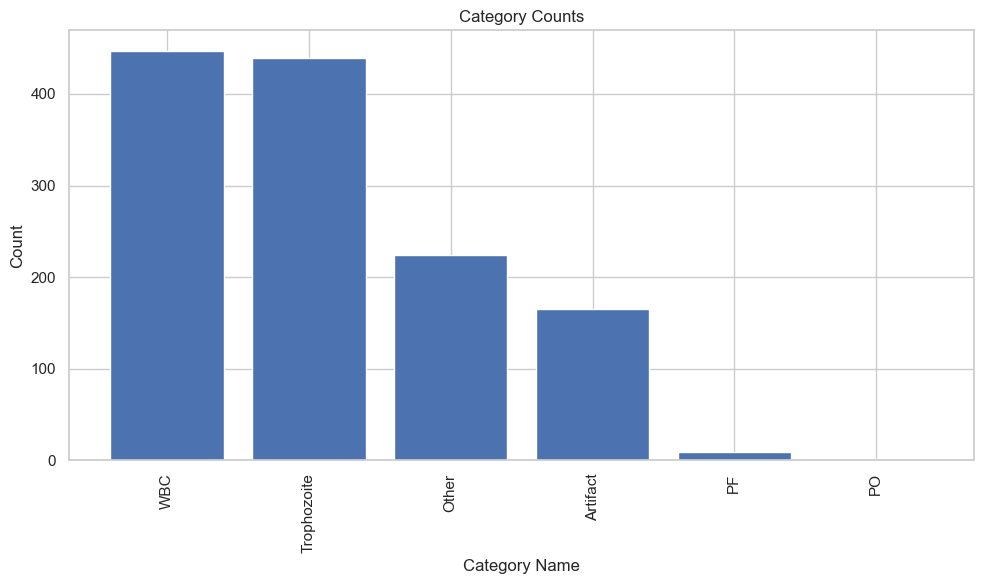

In [104]:
import matplotlib.pyplot as plt

# Get the count of each category
category_counts = slides_2['category_name'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(category_counts.index, category_counts.values)
plt.xlabel('Category Name')
plt.ylabel('Count')
plt.title('Category Counts')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [105]:
import pandas as pd
# Thick and Thin in annotations_df
kati_annotations_df['is_thick'] = kati_annotations_df['file_name'].str.contains('THICK', case=False)
kati_annotations_df['is_thin'] = kati_annotations_df['file_name'].str.contains('THIN', case=False)
annotation_thick = kati_annotations_df['is_thick']
annotation_thin = kati_annotations_df['is_thin']

thick_annotations = kati_annotations_df[annotation_thick]
thick_annotations = thick_annotations.drop('is_thick', axis = 1)
thick_annotations = thick_annotations.drop('is_thin', axis = 1)
thick_annotations = thick_annotations.drop('category_id', axis = 1)
thick_annotations= thick_annotations.drop('category_name', axis = 1)
thick_annotations= thick_annotations.groupby(['file_name','image_id']).size().reset_index(name='count')
length_thick_annotations = len(thick_annotations)
print(length_thick_annotations)

thin_annotations = kati_annotations_df[annotation_thin]
thin_annotations = thin_annotations.drop('is_thick', axis = 1)
thin_annotations = thin_annotations.drop('is_thin', axis = 1)
thin_annotations = thin_annotations.drop('category_id', axis = 1)
thin_annotations = thin_annotations.drop('category_name', axis = 1)
length_thin_annotations = len(thin_annotations)
print(length_thin_annotations)

662
1819


In [106]:
# Thick and Thin in metadata_df
metadata_df['is_thick'] = metadata_df['slide_name'].str.contains('THICK', case=False)
metadata_df['is_thin'] = metadata_df['slide_name'].str.contains('THIN', case=False)
metadata_thick = metadata_df['is_thick']
metadata_thin = metadata_df['is_thin']

thick_meta = metadata_df[metadata_thick]
thick_meta = thick_meta.drop('is_thick', axis = 1)
thick_meta = thick_meta.drop('is_thin', axis = 1)
thick_meta = thick_meta.drop('stain', axis = 1)
thick_meta = thick_meta.drop('username', axis = 1)
thick_meta = thick_meta.groupby(['timestamp','slide_name','zoom_ration']).size().reset_index(name='Number')
thick_meta = thick_meta.drop('Number', axis = 1)
length_thick_meta = len(thick_meta)
print(length_thick_meta)

thin_meta = metadata_df[metadata_thin]
thin_meta = thin_meta.drop('is_thick', axis = 1)
thin_meta = thin_meta.drop('is_thin', axis = 1)
thin_meta = thin_meta.drop('stain', axis = 1)
thin_meta = thin_meta.drop('username', axis = 1)
thin_meta = thin_meta.groupby(['timestamp','slide_name','zoom_ration']).size().reset_index(name='Number')
thin_meta = thin_meta.drop('Number', axis = 1)
length_thin_meta = len(thin_meta)
print(length_thin_meta)

2661
2472


In [107]:
import numpy as np
trophozoite_annotations = kati_annotations_df[kati_annotations_df['category_id'] == 1]

# Create a mapping of category_id to category_name
category_mapping = kati_annotations_df.groupby('category_id')['category_name'].first()

# Replacing category_id with category_name in the groupby column
trophozoite_annotations.loc[:,'category_id'] = trophozoite_annotations['category_id'].map(category_mapping)

trophozoite_annotations = trophozoite_annotations.groupby(['image_id','category_id']).size().reset_index(name='Number')
trophozoite_annotations.columns = ['Image_ID','Category_name','Number']
trophozoite_annotations.head(10)

,Image_ID,Category_name,Number
0,1,Trophozoite,27
1,2,Trophozoite,10
2,3,Trophozoite,36
3,4,Trophozoite,23
4,5,Trophozoite,35
5,6,Trophozoite,42
6,7,Trophozoite,36
7,8,Trophozoite,45
8,9,Trophozoite,36
9,10,Trophozoite,40


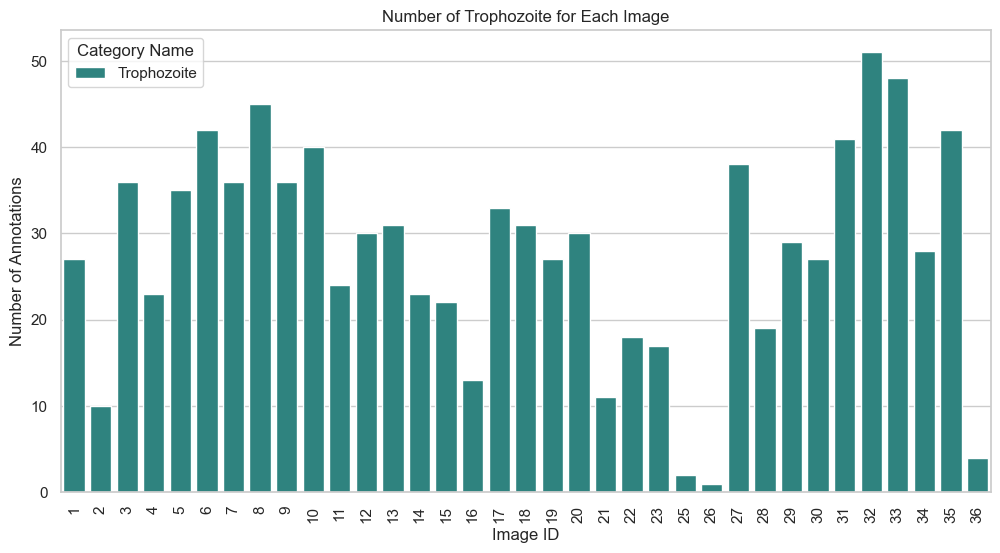

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming trophozoite_annotations is already defined as in your code
sns.set_theme(style="whitegrid")

# Select a range of images (e.g., the first 20 images)
image_range = trophozoite_annotations['Image_ID'].unique()[:35]

# Filter the data to only include the selected image range
filtered_data = trophozoite_annotations[trophozoite_annotations['Image_ID'].isin(image_range)]

# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Image_ID', y='Number', hue='Category_name', data=filtered_data, palette='viridis')
plt.title('Number of Trophozoite for Each Image')
plt.xlabel('Image ID')
plt.ylabel('Number of Annotations')
plt.legend(title='Category Name')
plt.xticks(rotation=90)
plt.show()

In [109]:
# For Thick
trophozoite_annotations['is_thick'] = metadata_df['slide_name'].str.contains('THICK', case=False)
trophozoite_thick = trophozoite_annotations['is_thick']

# New column indicating whether the slide is thick or thin
trophozoite_annotations.loc[:, 'Slide_Name'] = np.where(trophozoite_thick, 'Thick','Thin')
trophozoite_annotations_thick = trophozoite_annotations[trophozoite_thick]
trophozoite_annotations_thick = trophozoite_annotations_thick.drop('is_thick', axis = 1)

trophozoite_annotations_thick.head()
#trophozoite_annotations_thick.info()

,Image_ID,Category_name,Number,Slide_Name
0,1,Trophozoite,27,Thick
1,2,Trophozoite,10,Thick
2,3,Trophozoite,36,Thick
3,4,Trophozoite,23,Thick
4,5,Trophozoite,35,Thick


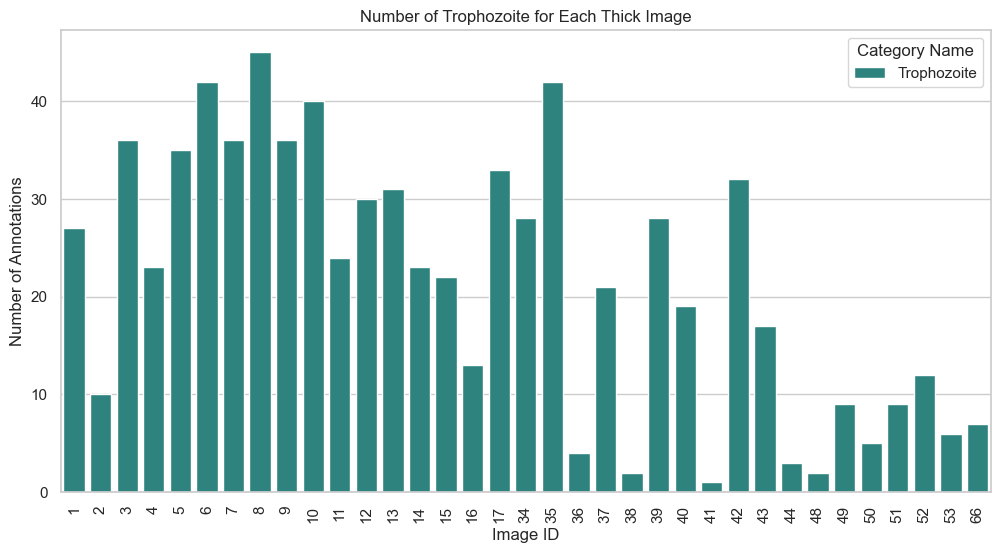

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# Range of images 
image_range = trophozoite_annotations_thick['Image_ID'].unique()[:35]

# Filter the data to only include the selected image range
filtered_data_thick = trophozoite_annotations_thick[trophozoite_annotations_thick['Image_ID'].isin(image_range)]

# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Image_ID', y='Number', hue='Category_name', data=filtered_data_thick, palette='viridis')
plt.title('Number of Trophozoite for Each Thick Image')
plt.xlabel('Image ID')
plt.ylabel('Number of Annotations')
plt.legend(title='Category Name')
plt.xticks(rotation=90)
plt.show()

In [111]:
# For Thin
trophozoite_annotations['is_thin'] = metadata_df['slide_name'].str.contains('THIN', case=False)
trophozoite_thin = trophozoite_annotations['is_thin']
# For Zoomratio
#trophozoite_annotations['zoom_ration'] = metadata_df['zoom_ration']

# New column indicating whether the slide is thick or thin
trophozoite_annotations.loc[:, 'Slide_Name'] = np.where(trophozoite_thin, 'Thin','Thick')
trophozoite_annotations_thin = trophozoite_annotations[trophozoite_thin]
trophozoite_annotations_thin = trophozoite_annotations_thin.drop('is_thin', axis = 1)
trophozoite_annotations_thin = trophozoite_annotations_thin.drop('is_thick', axis = 1)
trophozoite_annotations_thin.head()

,Image_ID,Category_name,Number,Slide_Name
17,18,Trophozoite,31,Thin
18,19,Trophozoite,27,Thin
19,20,Trophozoite,30,Thin
20,21,Trophozoite,11,Thin
21,22,Trophozoite,18,Thin


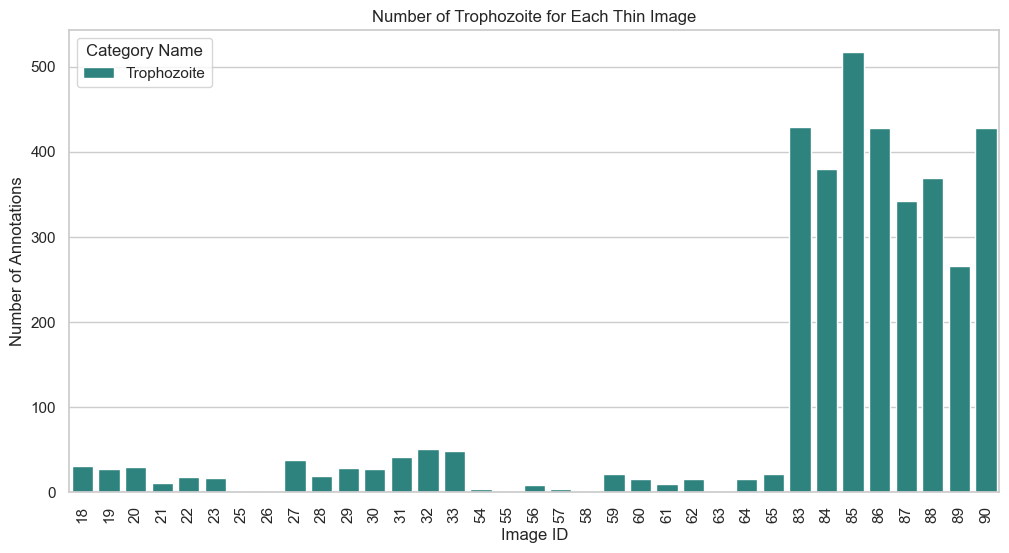

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# Range of images 
image_range = trophozoite_annotations_thin['Image_ID'].unique()[:35]

# Filter the data to only include the selected image range
filtered_data_thin = trophozoite_annotations_thin[trophozoite_annotations_thin['Image_ID'].isin(image_range)]

#annotation_range = filtered_data_thin['Number'].min(), filtered_data_thin['Number'].max()
#annotation_range = (0,45)

# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Image_ID', y='Number', hue='Category_name', data=filtered_data_thin, palette='viridis')
plt.title('Number of Trophozoite for Each Thin Image')
plt.xlabel('Image ID')
plt.ylabel('Number of Annotations')
plt.legend(title='Category Name')
plt.xticks(rotation=90)
plt.show()

In [113]:
schizont_annotations = kati_annotations_df[kati_annotations_df['category_id'] == 2]

schizont_annotations = schizont_annotations.groupby(['image_id']).size().reset_index(name='Number')
schizont_annotations['category_id'] = 2

category_mapping = kati_annotations_df[['category_id', 'category_name']].drop_duplicates()
schizont_annotations.loc[:,'category_id'] = schizont_annotations['category_id'].replace(category_mapping.set_index('category_id')['category_name'])
schizont_annotations.columns = ['Image_ID','Number','Category_name']
print(schizont_annotations.head())

Empty DataFrame
Columns: [Image_ID, Number, Category_name]
Index: []


In [115]:
gametocyte_annotations = kati_annotations_df[kati_annotations_df['category_id'] == 3]

gametocyte_annotations = gametocyte_annotations.groupby(['image_id']).size().reset_index(name='Number')
gametocyte_annotations['category_id'] = 3

category_mapping = kati_annotations_df[['category_id', 'category_name']].drop_duplicates()
gametocyte_annotations.loc[:,'category_id'] = gametocyte_annotations['category_id'].replace(category_mapping.set_index('category_id')['category_name'])
gametocyte_annotations.columns = ['Image_ID','Number','Category_name']
print(gametocyte_annotations)

Empty DataFrame
Columns: [Image_ID, Number, Category_name]
Index: []


In [116]:
wbc_annotations = kati_annotations_df[kati_annotations_df['category_id'] == 4]
wbc_annotations = wbc_annotations.drop('is_thick', axis = 1)
wbc_annotations = wbc_annotations.drop('is_thin', axis = 1)
wbc_annotations = wbc_annotations.groupby(['image_id','category_id']).size().reset_index(name='count')

print(wbc_annotations.head())

   image_id  category_id  count
0         1            4      5
1         2            4      7
2         3            4     10
3         4            4     11
4         5            4     18
